# Reverse MNIST

## Preliminaries

In [527]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

## Load MNIST DATA

In [528]:
howmany = -1 #50
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:howmany]).float().to(device), torch.tensor(train[1][:howmany]).float().to(device)]

## Create Network

In [465]:
# Shallow Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=784))  # 1 Input
net.Connect(0,1)
# Input layer is one-hot
net.layers[0].SetActivationFunction('softmax')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.04)

In [529]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=50))  # 1 Hidden
net.AddLayer(Layer.InputPELayer(n=200))  # 2 Hidden
net.AddLayer(Layer.TopPELayer(n=784))  # 3 Image
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
# Input layer is one-hot
net.layers[0].SetActivationFunction('softmax')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.08)

In [287]:
net.layers[0].Probe(True)
net.layers[1].Probe(True)

In [509]:
len(net.layers)

4

## Train the Network

In [ ]:
# Train in reverse direction: one-hot -> reconstructed image
epochs = 20
T = 3.
dt = 0.01
start_time = time.time()
batch_size = 100
net.learning_tau = torch.tensor(batch_size).float().to(device) * 15.
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[1], train[0], batch_size=batch_size)
    for x in batches:
        #net.Reset()
        net.Infer(T, x[0], x[1], dt=dt)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

## Probe the Model

In [313]:
z = net.Predict(10., train[1][0], dt=0.01)

In [314]:
plt.plot(net.t_history, np.array(net.layers[1].v_history)[:,200:300]);

IndexError: too many indices for array

## Save the Model

In [457]:
net.Save('MNIST reversed deep.npy')

## Load the Model

In [458]:
net = NN.NeuralNetwork()
net.Load('MNIST reversed.npy')

## Test the Network

In [531]:
net.layers[1].b

tensor([ 0.1048,  0.0330,  0.0986,  0.0726,  0.1080,  0.2098,  0.0191,
         0.0233,  0.0312,  0.0568,  0.0383,  0.0391,  0.0913,  0.1023,
         0.0592,  0.0234,  0.0222,  0.2528,  0.0453,  0.0486,  0.2191,
         0.0240,  0.0204,  0.1244,  0.0836,  0.0133,  0.0201,  0.0989,
         0.1354,  0.0671,  0.0097,  0.1484,  0.0433,  0.1391,  0.1165,
         0.0427,  0.0344,  0.0599,  0.0296,  0.0327,  0.0451,  0.1681,
         0.1925,  0.0542,  0.0509,  0.0511,  0.1166,  0.1107,  0.0423,
         0.0358], device='cuda:0')

tensor([ 0.0997,  0.1088,  0.1044,  0.1100,  0.0918,  0.0985,  0.0962,
         0.0996,  0.0870,  0.0993], device='cuda:0')


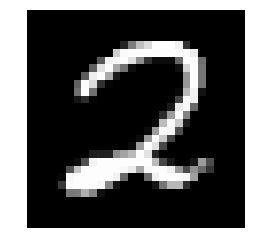

In [534]:
p = 35 #147 or 35   for 2s
#p = 133 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.SetTau(0.08)
z = net.Generate(3., test[0][p])
y = z #net.layers[1].sigma(z)
print(z)

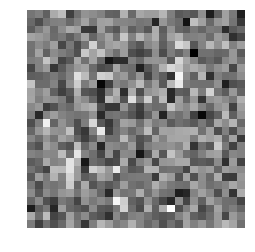

In [546]:
#net.Reset()
z = net.Predict(1., test[1][p])
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [547]:
net.Reset()
net.SetTau(0.08)  # it seems like choosing a value half of that during training works best
yy = net.Generate(8., test[0])
y_true = test[1]
y = np.array([np.array(Layer.softmax(k)) for k in yy])

In [540]:
sum(y[0])

tensor(0.9954, device='cuda:0')

In [548]:
z = np.array(deepcopy(y))
for idx, blah in enumerate(y):
    z[idx,:] = NN.OneHot(blah)

In [549]:
err = np.sum(np.abs(z-test[1]))/2.
print(err)
print('Accuracy = '+str((len(z)-err)/len(z)*100.)+'%')

8990.0
Accuracy = 10.100000000000001%
